## Question 4 - How often do players who make the first check win the game?

The goal of the game is checkmate, of which check is half the objective. From my experiences, checks are also signs of being on the offense, which more often than not is correlated with being in an advantageous position. If this correlation is correct, then making the first check is a sign of catching the early advantage. Thus, I am interested in seeing if the player who makes the first check ends up winning the game more often.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

### Data Preprocessing and Loading

For this question, we will be looking at many different time controls. As such, we will be loading the following variables:
- game_id,
- is_check, a binary value describing if the move makes a check,
- result, the winner of the game,
- move_ply, to keep track of which move the first check was made

For our subquestions, we will also be stratifying on
- player elo,
- time control,
-remaining clock time, and
-board evaluation,
so we also have to load these values in.

These are a lot of variables. However, for both our main and sub questions, we will represent each game by one row of data. Thus, we should instead write a helper function that can be used to compress each chunk of moves into a smaller chunk with one row for each game.

One issue to keep track of is the game might not necessarily end at the given chunk boundaries. For example, if the chunks of data as read in is $10^6$ rows each, if the last game in the first chunk starts on row $999998$ for example, then we will not observe a check at all. As such, for each chunk, we will discard the first and last game id, as the resulting data will still be representative of the total population of games. This is a solution intended to bypass the memory limitations.

In [2]:
# these variables we can change
columns_to_load = ['game_id', 'result', 'is_check', 'move_ply', 'white_elo', 'black_elo', 'type', 'num_ply', 'termination']
dtype = {'game_id':str, 'result':str, 'is_check':bool, 'move_ply':int, 'white_elo':int, 'black_elo':int, 'type':str, 'num_ply':int, 'termination':str}

# a helper function used to:
# 1. drop the first and last game id in each chunk
# 2. drop the games that were not won by checkmate
# Then, we compress each game to one row by:
# a) finding the first row for each game_id where is_check is true, and storing the move number
# b) determining if white or black made the first check, as a boolean called white_check
# c) storing the winner as a -1, 0, or 1 instead of strings (three cases means we cannot use a boolean)
def compress(df):
  # step 1
  df = df[~df['game_id'].isin([df['game_id'].iloc[0], df['game_id'].iloc[-1]])]
  # step 2
  df = df[df['termination'] == 'Normal']
  # step a
  df_checks = df.loc[df['is_check'], ['game_id', 'move_ply']].rename(columns={'move_ply':'check_ply'}).groupby('game_id', sort=False).first()
  # compress each game to one row
  df = df.drop(columns=['is_check', 'move_ply', 'termination']).drop_duplicates(subset='game_id')
  # merge back into df
  df = pd.merge(df, df_checks, on='game_id', how='left')
  df['check_ply'] = df['check_ply'] + 1 # add 1 to 1-index the ply instead of 0-index
  # if we have NA in the check_ply column, that means checkmate was the first check of the game, so we set these values
  df['check_ply'] = df['check_ply'].fillna(df['num_ply'])
  # step b (even is white because move_ply is originally 0-indexed, but we added 1)
  df['first_check_by'] = df['check_ply'] % 2 == 1
  df['first_check_by'] = df['first_check_by'].map({True: 'white', False: 'black'})
  df['first_check_by'] = df['first_check_by'].fillna(df['result'])
  # step c
  df['result'] = df['result'].map({'1-0': 'white', '0-1': 'black'}).fillna('draw')
  df.rename(columns={'result': 'winner'}, inplace=True)
  # return
  return df

I've tested the helper function on a few smaller chunks first. It took about 80 seconds to load and compress 3 chunks of size 1e3 rows. It takes about 8 minutes to read 200 chunks of size 1e5 rows, or 20 chunks of size 1e6.

In [3]:
url = "https://csslab.cs.toronto.edu/data/chess/monthly/lichess_db_standard_rated_2019-01.csv.bz2"

max_chunks = 200
chunksize = 1e6
chunk_counter = 0
filtered_chunks = []

start_time = time.time()
for chunk in pd.read_csv(url, compression='bz2', usecols = columns_to_load, chunksize=chunksize, dtype=dtype):
    filtered_chunks.append(compress(chunk))
    chunk_counter += 1

    if chunk_counter >= max_chunks:
      # if max_chunks is greater than the number of chunks, the loop also automatically breaks
        break

df = pd.concat(filtered_chunks, ignore_index=True)
df_original = df.copy() # store a copy in case we want to revert the analysis to this checkpoint at any time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to read the first {chunk_counter} chunks of size {chunksize:.2e}: {elapsed_time:.2f} seconds")

print(df.shape)
df.head()

Time taken to read the first 152 chunks of size 1.00e+06: 2929.81 seconds
(1824296, 8)


,game_id,type,winner,white_elo,black_elo,num_ply,check_ply,first_check_by
0,MVfPHhJJ,Blitz,white,1474,1465,33,26.0,black
1,0p86vQ56,Blitz,white,1467,1448,47,13.0,white
2,BhE80eZk,Bullet,black,2463,2564,38,38.0,black
3,fI1gvk1X,Blitz,black,1004,1019,38,25.0,white
4,y02F9Zen,Blitz,white,1334,1286,75,16.0,black


In [4]:
df = df_original # In case I accidentally replace df, I can restore it without loading in all the data again

We are going to be making heatmaps as visualizations because our two variables are who makes the first check and who wins. These variables have 2 and 3 possible outcomes, respectively, so the heatmap will be a $2 \times 3$ grid. As such, let's make a function that we can call to create a heatmap.

In [5]:
def heatmap(df, title, ax=None):
  # assuming we want to use all the data in the dataframe df, which has a winner and first_check_by column.
  joint_distribution = pd.crosstab(df['winner'], df['first_check_by'])

  opp = ((df['winner'] == 'black') & (df['first_check_by'] == 'white')) | \
              ((df['winner'] == 'white') & (df['first_check_by'] == 'black'))
  same = len(df[df['winner'] == df['first_check_by']])
  total = len(df)
  perc_opp = (opp.sum() / total) * 100
  perc_same = (same / total) * 100

  if (ax == None): # No subplots
    # Plot the heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(joint_distribution, annot=True, cmap="Blues", fmt="d")
    plt.xlabel("First Check Made by")
    plt.ylabel("Winner")
    plt.title(f"""{title}: {total}
    Percentage Same: {perc_same:.2f}%
    Percentage Opposing: {perc_opp:.2f}%""")
    plt.show()

  else: # Subplots
    sns.heatmap(joint_distribution, annot=True, cmap="Blues", fmt="d", ax=ax, vmin=0)
    ax.set_xlabel("First Check Made by")
    ax.set_ylabel("Winner")
    ax.set_title(f"""{title}: {total}
    Percentage Same: {perc_same:.2f}%
    Percentage Opposing: {perc_opp:.2f}%""")

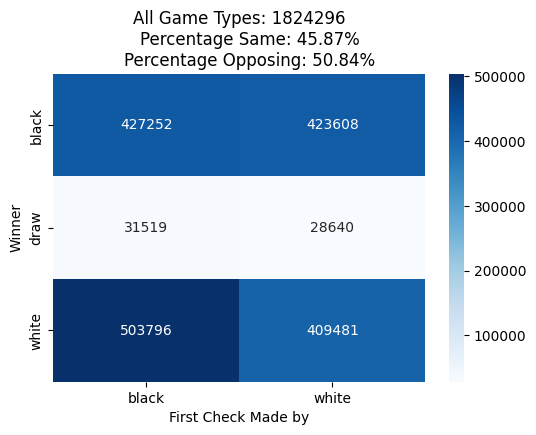

In [6]:
# Call the function we just defined
heatmap(df, "All Game Types")

This result is surprising! I would expect either that the winner is independent of whoever makes the first check or that the person who makes the first check wins more often than not, but in fact, neither of these are true. The person who makes the first check more often than not loses.

One concern we might have is that the first check is actually checkmate. In these games, the winner must be the person who plays the first check. We are interested in seeing how large a slice of the dataset this subset makes up.

### Question 4.1.1 - How often is the first check also linked with the end of the game?

In [7]:
checkmates = (df['num_ply'] == df['check_ply']).sum()
total = len(df)
prop = checkmates / total

print(f"Percentage of Games where the First Check is Checkmate: {(100 * prop):.2f}%")

Percentage of Games where the First Check is Checkmate: 12.14%


This is actually pretty significant! If we remove these games, what does the resulting heatmap look like?

First, store the original preprocessed dataframe, in case we want to use it again in the future as a checkpoint.

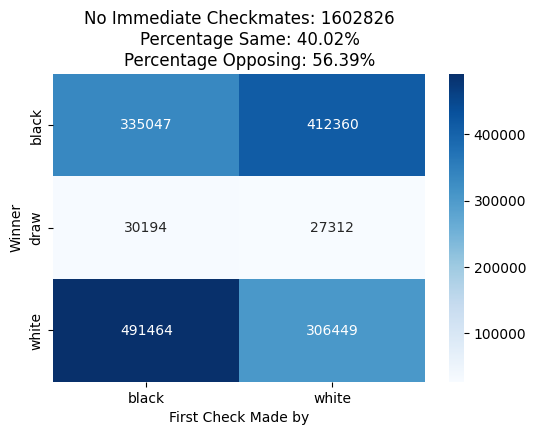

In [8]:
df_nomate = df.loc[df['num_ply'] != df['check_ply'], :]

heatmap(df_nomate, "No Immediate Checkmates")

The disparity becomes even larger. This is not surprising because every game that got removed was a game that fell under the "Same" category, since in those games, players who made the first check immediately won. However, now that we removed the games where the check did not immediately cause checkmate, we note that when a player makes a check that does not end the game, over 56% of the time this player loses.

We explore in Question 4.2.x if this result is consistent if we stratify on some of our other variables, but first, let's see if this percentage changes depending on when the first check is made.

### Question 4.1.2 - Is the probability that the first check is checkmate dependent on the ply number of the first check?

For each possible ply number, we observe the percentage of those games whose first checks were made on that move that immediately ended.

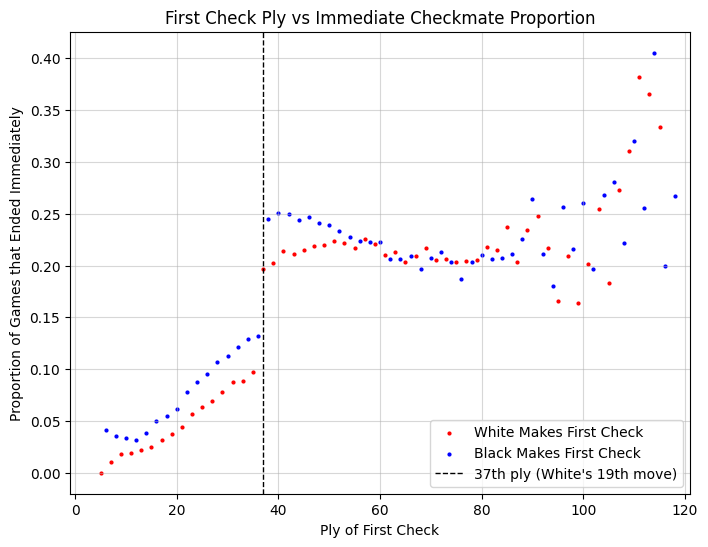

In [34]:
max_ply = 120
cutoff = 30 # we only care about the average if there is a sizable amount of data for a particular ply length. I chose 30 because of the CLT.

check_avg = []

for n_ply in range(max_ply+1):
  df_sub = df[df['check_ply'] == n_ply]['num_ply']
  if (len(df_sub) < cutoff):
    check_avg.append(None)
  else:
    check_avg.append((df_sub == n_ply).mean())

x = [i+1 for i, value in enumerate(check_avg) if value is not None]
y = [value for value in check_avg if value is not None]

plt.figure(figsize=(8,6))
plt.xlim([-1,max_ply+1])

plt.scatter([xi for xi in x if xi % 2 == 1],
            [yi for xi, yi in zip(x, y) if xi % 2 == 1],
            c='red', s=4, label='White Makes First Check')
plt.scatter([xi for xi in x if xi % 2 == 0],
            [yi for xi, yi in zip(x, y) if xi % 2 == 0],
            c='blue', s=4, label='Black Makes First Check')

plt.axvline(x=37, linestyle='--', color='black', lw=1, label='37th ply (White\'s 19th move)')

plt.xlabel("Ply of First Check")
plt.ylabel("Proportion of Games that Ended Immediately")
plt.title("First Check Ply vs Immediate Checkmate Proportion")

plt.legend()
plt.grid(alpha=0.5)
plt.show()

I am not sure what the reason for the discontinuity at the 37th ply is, but that is really interesting... Before the discontinuity, both rates seem to be increasing in unison, but afterwards, they seem to average out at about $x=60$, and then after that, it appears to be more random.

### Question 4.2.1 - Is the result consistent upon stratification on time control?

In [9]:
unique_types = df['type'].unique()
print(unique_types)
print(f"There are {len(unique_types)} types.")

['Blitz' 'Bullet' 'Rapid' 'Classical' 'UltraBullet' 'Correspondence']
There are 6 types.


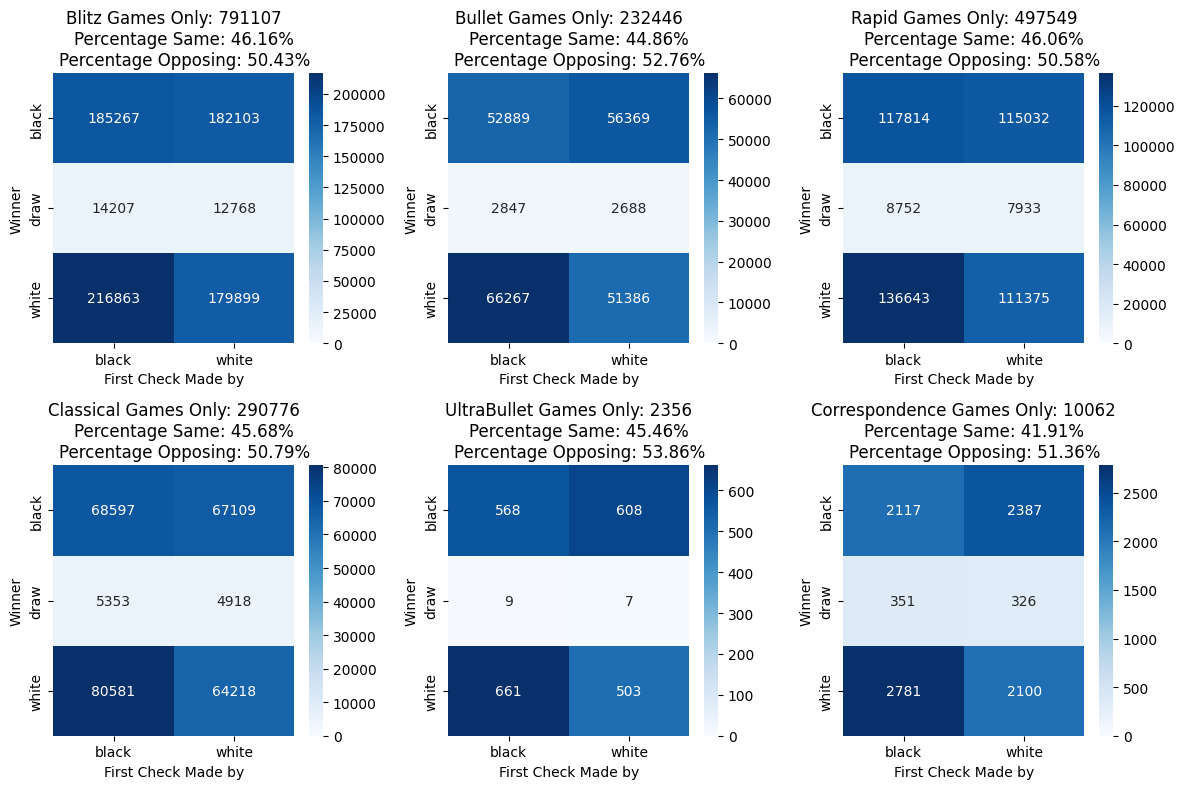

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, type_value in enumerate(unique_types):
  df_sub = df[df['type'] == type_value]
  heatmap(df_sub, f"{type_value} Games Only", axes[i])

plt.tight_layout()
plt.show()

Some interesting results:
- Correspondence has the highest draw rate, almost 10%, and has the lowest Same percentage.
- Ultrabullet has the lowest draw rate, and the highest Opposing percentage.
- As the amount of time that the players have increase, the further the Opposing percentage decreases, which decreases asymptotically to 50%.

### Question 4.2.2 - Is the result consistent upon stratification on player elo?

For this question, knowing that Lichess lower bounds their elo at 800 during 2019, I chose to set quartiles at 1200, 1600, and 2000. First, add a column for the average elo between the two players to df.

In [11]:
df['elo'] = (df['white_elo'] + df['black_elo']) / 2
df.head()

,game_id,type,winner,white_elo,black_elo,num_ply,check_ply,first_check_by,elo
0,MVfPHhJJ,Blitz,white,1474,1465,33,26.0,black,1469.5
1,0p86vQ56,Blitz,white,1467,1448,47,13.0,white,1457.5
2,BhE80eZk,Bullet,black,2463,2564,38,38.0,black,2513.5
3,fI1gvk1X,Blitz,black,1004,1019,38,25.0,white,1011.5
4,y02F9Zen,Blitz,white,1334,1286,75,16.0,black,1310.0


Now, make a column that groups the games by elo quadrant.

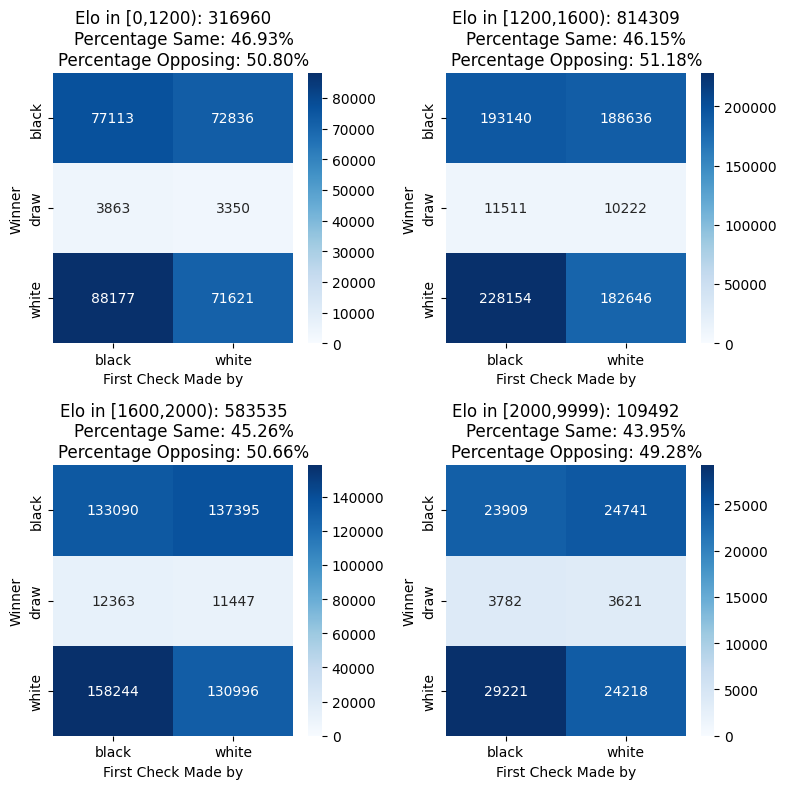

In [12]:
elo_quadrant_bounds = [0, 1200, 1600, 2000, 9999]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for i in range(len(elo_quadrant_bounds) - 1):
  lower_bound = elo_quadrant_bounds[i]
  upper_bound = elo_quadrant_bounds[i+1]
  df_sub = df[(df['elo'] >= lower_bound) & (df['elo'] < upper_bound)]
  heatmap(df_sub, f"Elo in [{lower_bound},{upper_bound})", axes[i])

plt.tight_layout()
plt.show()

One interesting result is that among all of the heatmaps, the most frequent of the six cells is almost always the cell where Black makes the first check but White ends up winning. In other words, in games where White makes the first check, Black has a slightly higher chance of winning, while in games where Black makes the first check, White has a much larger chance of winning. Maybe this is caused by something...?

### Question 4.2.3 - What if we stratify on both time control and player elo?

Stratification on two (or more) variables is difficult to visualize. Let's do this by finding the same, opposing, and draw percentages as before, and storing them in a table.

In [13]:
df.columns

Index(['game_id', 'type', 'winner', 'white_elo', 'black_elo', 'num_ply',
       'check_ply', 'first_check_by', 'elo'],
      dtype='object')

In [14]:
import itertools

elo_bin_strings = []
# This is to create strings for the elo bins
for i in range(len(elo_quadrant_bounds) - 1):
  lower_bound = elo_quadrant_bounds[i]
  upper_bound = elo_quadrant_bounds[i+1]
  elo_bin_strings.append(f"{lower_bound} to {upper_bound}")

data_list = []

# Now calculate some proportions for each of the strata
for i in range(len(elo_quadrant_bounds) - 1):
  lower_bound = elo_quadrant_bounds[i]
  upper_bound = elo_quadrant_bounds[i+1]
  df_sub = df.loc[(df['elo'] >= lower_bound) & (df['elo'] < upper_bound), ['type', 'winner', 'first_check_by']]
  for type_value in unique_types:
    df_sub_sub = df_sub[df_sub['type'] == type_value]

    opp = len(df_sub_sub[(df_sub_sub['winner'] != 'draw') & (df_sub_sub['winner'] != df_sub_sub['first_check_by'])])
    same = len(df_sub_sub[df_sub_sub['winner'] == df_sub_sub['first_check_by']])
    draw = len(df_sub_sub[df_sub_sub['winner'] == 'draw'])
    total = len(df_sub_sub) # Normalize each combination
    prop_opp = round(100 * opp / total, 3)
    prop_same = round(100 * same / total, 3)
    prop_draw = round(100 * draw / total, 3)

    row_values = {
        'Type': type_value,
        'Player Elo Bin': elo_bin_strings[i],
        'Frequency': total,
        'Same %': prop_same,
        'Opposing %': prop_opp,
        'Draw %': prop_draw
    }
    data_list.append(row_values)

# Now, store the results in a dataframe
df_doublestrata = pd.DataFrame(data_list)

df_doublestrata

,Type,Player Elo Bin,Frequency,Same %,Opposing %,Draw %
0,Blitz,0 to 1200,165677,46.991,50.556,2.452
1,Bullet,0 to 1200,37520,45.586,52.441,1.972
2,Rapid,0 to 1200,72941,47.422,50.479,2.099
3,Classical,0 to 1200,40754,47.021,50.824,2.154
4,UltraBullet,0 to 1200,32,37.500,62.500,0.000
5,Correspondence,0 to 1200,36,30.556,66.667,2.778
6,Blitz,1200 to 1600,332745,46.407,50.715,2.878
7,Bullet,1200 to 1600,97281,45.101,52.951,1.948
8,Rapid,1200 to 1600,232554,46.466,50.876,2.658
9,Classical,1200 to 1600,146646,45.873,51.502,2.625


Let's drop the rows with games fewer than a certain cutoff, and then sort by the opposing percentage, which I think is the most interesting.

None of the strata have a Same Percentage above 50%. The closest is still less than 47%. Meanwhile, almost all of the Opposing Percentages are above 50%.

In [15]:
cutoff = 300
df_doublestrata[df_doublestrata['Frequency'] >= cutoff].sort_values(by='Opposing %', ascending=False).reset_index(drop=True)

,Type,Player Elo Bin,Frequency,Same %,Opposing %,Draw %
0,UltraBullet,2000 to 9999,480,37.917,60.000,2.083
1,UltraBullet,1600 to 2000,1105,46.063,53.575,0.362
2,Correspondence,1200 to 1600,4344,41.390,53.361,5.249
3,Bullet,1600 to 2000,74549,44.624,53.056,2.319
4,Bullet,1200 to 1600,97281,45.101,52.951,1.948
5,Bullet,0 to 1200,37520,45.586,52.441,1.972
6,Bullet,2000 to 9999,23096,43.423,51.507,5.070
7,Classical,1200 to 1600,146646,45.873,51.502,2.625
8,Rapid,1200 to 1600,232554,46.466,50.876,2.658
9,Classical,0 to 1200,40754,47.021,50.824,2.154


This visualization shows some interesting results. There may not seem to be a particular trend, but the last two rows are both the highest elo quadrant, while this quadrant appears nowhere in the first half of the table. (The first row is the exact middle row of the table.) Also, the top 5 rows are all very fast, ie Bullet and Ultrabullet, except for Correspondence.

### Question 4.3.1 - How is the ply number of the first check distributed for a game of a certain game length?

Note: This question was originally "How often is the first check used as a last ditch effort?", which has been moved to Question 7.

Chess engines will play checks if possible to delay an inevitable loss, and human players sometimes do this as well. Thus, maybe the check is actually used in defense. We explore this question more thoroughly in Question 7. Here, we only analyze the distribution of when the first check is made in the game.

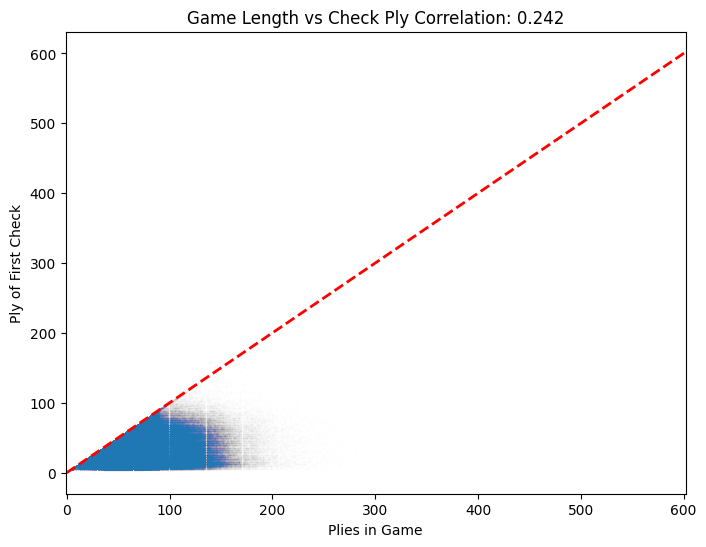

In [16]:
corr = df['num_ply'].corr(df['check_ply'])

max_ply = df['num_ply'].max()

plt.figure(figsize=(8,6))
plt.plot([0,max_ply], [0,max_ply], lw=2, c='red', linestyle='dashed')
plt.scatter(df['num_ply'], df['check_ply'], s=0.5, alpha=0.002)
plt.xlim([-1,max_ply+1])

plt.xlabel("Plies in Game")
plt.ylabel("Ply of First Check")
plt.title(f"Game Length vs Check Ply Correlation: {corr:.3f}")

plt.show()

Let's zoom in on the bottom left.

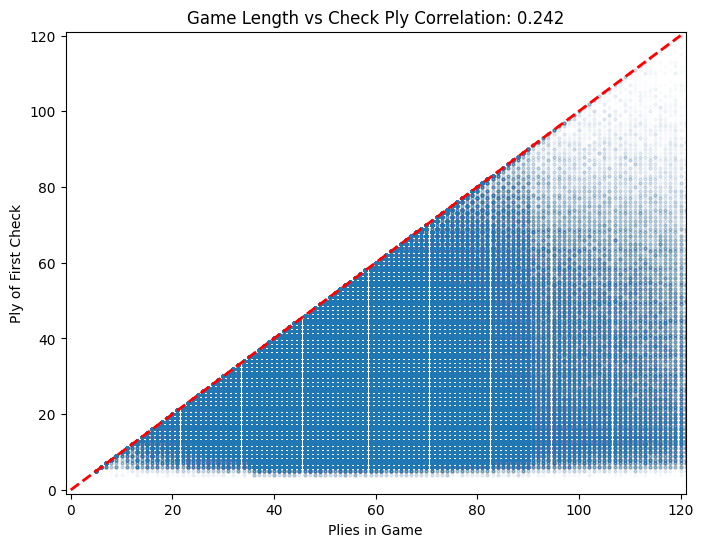

In [17]:
max_ply = 120

plt.figure(figsize=(8,6))
plt.plot([0,max_ply], [0,max_ply], lw=2, c='red', linestyle='dashed')
plt.scatter(df['num_ply'], df['check_ply'], s=4, alpha=0.01)
plt.xlim([-1,max_ply+1])
plt.ylim([-1,max_ply+1])

plt.xlabel("Plies in Game")
plt.ylabel("Ply of First Check")
plt.title(f"Game Length vs Check Ply Correlation: {corr:.3f}")

plt.show()

The red, dashed line is the $45^\circ$ line. Games on this line are games where the first check made resulted immediately in checkmate. We can split the games into three sections.
- For games less than 30 plies, more games are closer to the red line, which indicates that faster games tend to avoid "unwinning" checks, ie checks that are not also checkmate.
- For games between 35 and 70 plies, the distribution looks roughly uniform between 6 and the number of plies.
- For games longer than 70 plies, the distribution tends to skew towards the lower bound.

Now, let's calculate the average ply of the first check for each value of num_ply, and see if this line graph tells us anything more useful.

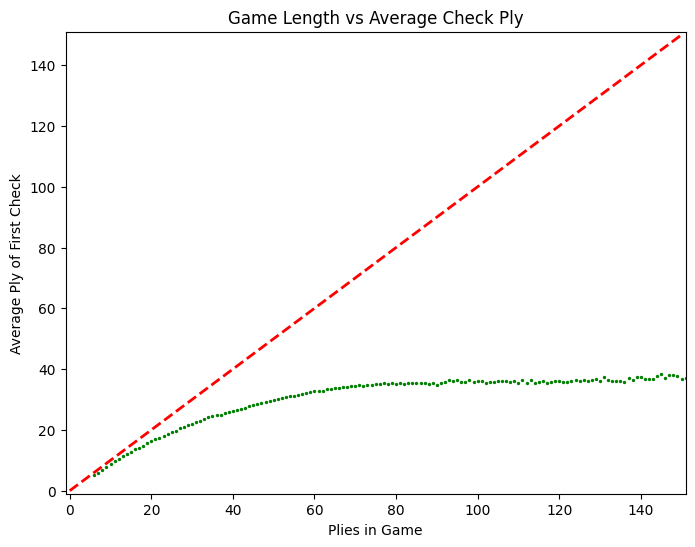

In [18]:
max_ply = 150
cutoff = 30 # we only care about the average if there is a sizable amount of data for a particular ply length. I chose 30 because of the CLT.

check_avg = []

for n_ply in range(max_ply+1):
  df_sub = df[df['num_ply'] == n_ply]['check_ply']
  if (len(df_sub) < cutoff):
    check_avg.append(None)
  else:
    check_avg.append(df_sub.mean())

x = [i+1 for i, value in enumerate(check_avg) if value is not None]
y = [value for value in check_avg if value is not None]

plt.figure(figsize=(8,6))
plt.plot([0,max_ply], [0,max_ply], lw=2, c='red', linestyle='dashed')
plt.scatter(x, y, c='green', s=2)
plt.xlim([-1,max_ply+1])
plt.ylim([-1,max_ply+1])

plt.xlabel("Plies in Game")
plt.ylabel("Average Ply of First Check")
plt.title("Game Length vs Average Check Ply")

plt.show()

The average is not linear, so it does not make sense to calculate and interpret the correlation or linear regression output.

### Question 4.3.2 - How is the game length distributed for a game where the first check is made on a particular ply?

This question is, arguably, more interesting, because during a game, we observe the ply number of the first check before observing how many moves it lasts. Again, we only plot the average game duration on the Y.

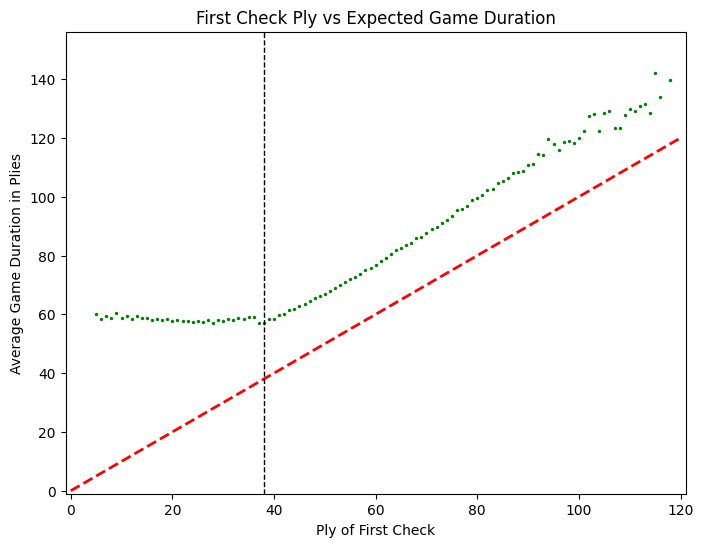

In [19]:
max_ply = 120
cutoff = 30 # we only care about the average if there is a sizable amount of data for a particular ply length. I chose 30 because of the CLT.

check_avg = []

for n_ply in range(max_ply+1):
  df_sub = df[df['check_ply'] == n_ply]['num_ply']
  if (len(df_sub) < cutoff):
    check_avg.append(None)
  else:
    check_avg.append(df_sub.mean())

x = [i+1 for i, value in enumerate(check_avg) if value is not None]
y = [value for value in check_avg if value is not None]

plt.figure(figsize=(8,6))
plt.plot([0,max_ply], [0,max_ply], lw=2, c='red', linestyle='dashed')
plt.scatter(x, y, c='green', s=2)
plt.xlim([-1,max_ply+1])
plt.ylim([-1, max(y) * 1.1])

plt.axvline(x=38, linestyle='--', color='black', lw=1)

plt.xlabel("Ply of First Check")
plt.ylabel("Average Game Duration in Plies")
plt.title("First Check Ply vs Expected Game Duration")

plt.show()

This graph is *very* interesting to me. The average game length for when the first check is within the first $38$ plies is consistently around $60$ moves, but after this, it begins to increase linearly. The line looks about parallel to the red line, which is the $45^\circ$ line, so the slope would be around $1$. Let's plot this graph again with the line of best fit for the points up to

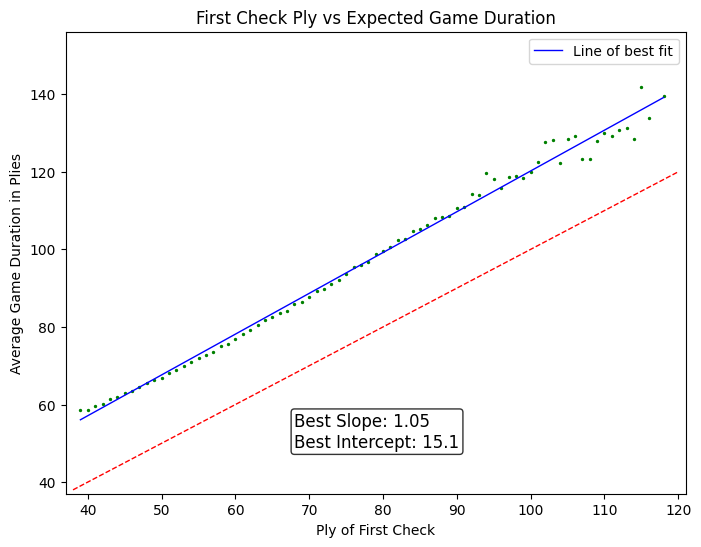

In [27]:
filtered_x = np.array(x)[np.array(x) > 38]
filtered_y = np.array(y)[np.array(x) > 38]

# Fit a line of best fit to the filtered data
coefficients = np.polyfit(filtered_x, filtered_y, 1)  # Linear fit (degree 1)
line_of_best_fit = np.poly1d(coefficients)

plt.figure(figsize=(8,6))
plt.plot([38,max_ply], [38,max_ply], lw=1, c='red', linestyle='dashed')
plt.scatter(filtered_x, filtered_y, c='green', s=2)
plt.plot(filtered_x, line_of_best_fit(filtered_x), lw=1, color='blue', label='Line of best fit')
plt.xlim([37,max_ply+1])
plt.ylim([37, max(y) * 1.1])

plt.xlabel("Ply of First Check")
plt.ylabel("Average Game Duration in Plies")
plt.title("First Check Ply vs Expected Game Duration")

plt.text(68, 58, f'Best Slope: {coefficients[0]:.2f}\nBest Intercept: {coefficients[1]:.1f}', fontsize=12, verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.2'))

plt.legend()
plt.show()

Now the new question is, why? Why does this seemingly piecewise relationship occur? And in the previous graph, why is it so nice?

### Question 4.4.1 - How often does the player with a lower elo make the first check?

The player with the lower elo and the player who made the first check both are binary variables. (If it's a tie, we alternate between assigning one player as having a lower elo.) This means we can make a confusion matrix-esque visualization.

In [21]:
df = df_original
df.head() # First, restore our data

,game_id,type,winner,white_elo,black_elo,num_ply,check_ply,first_check_by,elo
0,MVfPHhJJ,Blitz,white,1474,1465,33,26.0,black,1469.5
1,0p86vQ56,Blitz,white,1467,1448,47,13.0,white,1457.5
2,BhE80eZk,Bullet,black,2463,2564,38,38.0,black,2513.5
3,fI1gvk1X,Blitz,black,1004,1019,38,25.0,white,1011.5
4,y02F9Zen,Blitz,white,1334,1286,75,16.0,black,1310.0


In [22]:
alternate = True
def lower_elo(row):
    if row['white_elo'] < row['black_elo']:
        return 'white'
    elif row['black_elo'] < row['white_elo']:
        return 'black'
    else:
        return 'equal'

df['lower_elo'] = df.apply(lower_elo, axis=1)
df['elo_difference'] = abs(df['white_elo'] - df['black_elo'])
df = df[df['lower_elo'] != 'equal']
df.head()

,game_id,type,winner,white_elo,black_elo,num_ply,check_ply,first_check_by,elo,lower_elo,elo_difference
0,MVfPHhJJ,Blitz,white,1474,1465,33,26.0,black,1469.5,black,9
1,0p86vQ56,Blitz,white,1467,1448,47,13.0,white,1457.5,black,19
2,BhE80eZk,Bullet,black,2463,2564,38,38.0,black,2513.5,white,101
3,fI1gvk1X,Blitz,black,1004,1019,38,25.0,white,1011.5,white,15
4,y02F9Zen,Blitz,white,1334,1286,75,16.0,black,1310.0,black,48


Now create a frequency matrix.

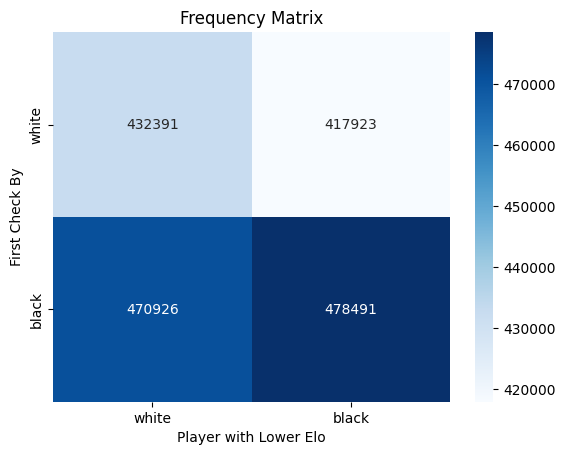

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['first_check_by'], df['lower_elo'], labels=['white', 'black'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['white', 'black'], yticklabels=['white', 'black'])
plt.xlabel('Player with Lower Elo')
plt.ylabel('First Check By')
plt.title('Frequency Matrix')
plt.show()

In [24]:
total = len(df)
lower_first_check_rate = (cm[0][1] + cm[1][0]) / total * 100
print(f"Player with a Lower Elo makes the First Check: {lower_first_check_rate:.2f}%")
white_first_check_rate = (cm[0][0] + cm[0][1]) / total * 100
print(f"White makes the First Check: {white_first_check_rate:.2f}%")
white_lower_elo_rate = (cm[0][0] + cm[1][0]) / total * 100
print(f"White has a Lower Elo: {white_lower_elo_rate:.2f}%")

Player with a Lower Elo makes the First Check: 49.39%
White makes the First Check: 47.25%
White has a Lower Elo: 50.19%


It turns out that across all games where the players have different elos, the player that makes the first check is effectively randomly decided. However, Black is more likely to make the first check, but since there the player with a lower elo is equally likely to play as white or black, the probability that this is also the player who makes the first check also comes out to about 50/50.

### Question 4.4.2 - Is there a relationship between the difference in elo between the two players and the chance that the player with lower elo makes the first check?

Now, I want to test whether or not seeing one's opponent as being significantly higher elo than oneself prompts oneself to play differently with the checks. I first bin the differences in bins of width $20$, as a difference of less than $20$ is negligible, as that can be flipped after just one game.

In [25]:
bin_labels = range(0, 300, 20)
# I choose to cut off the maximum difference at 300, as it is unlikely to naturally be pitted against a player that far away in elo from oneself
df.loc[:, 'elo_bin'] = pd.cut(df['elo_difference'], bins=bin_labels, right=False, include_lowest=True)

def calc_percentage(group):
    return (group['lower_elo'] == group['first_check_by']).mean() * 100

df_higher_checks = df.groupby('elo_bin', observed=False).apply(calc_percentage, include_groups=False).reset_index(name='percentage')
bin_frequency = df.groupby('elo_bin', observed=False).size().reset_index(name='frequency')

df_higher_checks = df_higher_checks.merge(bin_frequency, on='elo_bin')

freq_cutoff = 200
df_higher_checks = df_higher_checks[df_higher_checks['frequency'] >= freq_cutoff]

print(df_higher_checks)

<ipython-input-25-a326a82e8db2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'elo_bin'] = pd.cut(df['elo_difference'], bins=bin_labels, right=False, include_lowest=True)


       elo_bin  percentage  frequency
0      [0, 20)   50.085508     482413
1     [20, 40)   50.118149     343211
2     [40, 60)   50.388362     234189
3     [60, 80)   50.695866     164615
4    [80, 100)   50.174386     118989
5   [100, 120)   50.990297      87297
6   [120, 140)   51.250715      66442
7   [140, 160)   51.050225      51608
8   [160, 180)   51.399510      41193
9   [180, 200)   51.826134      33267
10  [200, 220)   52.117729      27317
11  [220, 240)   51.774861      22706
12  [240, 260)   52.736397      18930
13  [260, 280)   52.033952      15905


The percentage is pretty consistent around $50-52\%$, but it does slightly increase as the difference widens. Recall that this percentage measures the percent of the time that the player with higher elo also makes the first check.

Since the elo is the only thing that a player can observe of their opponent when playing online, perhaps players feel more endangered when they see that their difference is larger, and thus are more prompted to play an offensive check to cope.

## Results and Takeaways

We looked at the entire January 2019 dataset, and made the following observations.

1.   The player who makes the first check loses the game more often than they win, and this is consistent upon stratifying against elo and time control. The difference in the probabilities is approximately $5\%$.
2.   When the player playing White makes the first check, the player playing Black wins a little over half the time. When the player playing Black makes the first check, the player playing White wins significantly more than half the time.
3. If the first check is not checkmate, then the player who made the first check ends up losing $56\%$ of the time.
4. The player playing black makes the first check more often than the player playing white.
5. About $12\%$ of the time, the first check *is* checkmate.
6. For a given number of plies that a game is known to last for, as the number of plies increases, the expected ply of the first check in the game asymptotically increases towards about $40$.
7. If the first check was made before the $38$th ply, then the game is expected to last $60$ plies. Otherwise, it will last on average about $15$ moves longer.
8. The player with lower elo makes the first check about $50\%$ of the time, but this probability increases as the gap between the players' elo increases.


Next Steps and Potential Further Analysis:
- Observation 4 could lead to an analysis about how players perceive being the second to play.
- Observation 8 could lead to an analysis about how players who perceive themselves as being weaker than their opponents play differently.
- The difference recorded in Observation 2 is very interesting, but I also cannot explain it as of right now.
- Following up on Observation 7, if the first check is on ply $n$, no game could have ended in less than $n$ moves, so it is interesting that the expected additional number of moves is so low.
- The relationship between making the first check and losing is certainly not causal. For example, one potential confounder is the evaluation of the board when the first check is made. If the player is already losing, then they might make a check to prolong their demise, as engines often do. We observe if this has a significant impact in Question 7.
- There seems to be something peculiar about the 37th ply. In both our results for Questions 4.1.2 and 4.3.2, we observe scatterplots that approximately resemble piecewise functions that split at the 37th ply.